In [1]:
import json
import numpy as np
from os.path import join

RESULTS_FOLDER = '../results'
SUBSETS = ['train_cnn', 'val', 'train_rnn', 'test']
FOLDS = [str(fold) for fold in range(1, 11)]
BEST_MODELS = [
    ('hp_cr', '56'),
    ('hp_po', '63'),
    ('hp_pr', '29'),
    ('hp_ro', '14'),
    ('hp_sh', '66'),
    ('hp_tf', '5'),
]

def get_metrics(exp_name, model_id):
    metrics_path = join(
        RESULTS_FOLDER, exp_name, f'model_{model_id}', 'metrics.json'
    )
    with open(metrics_path, 'r') as metrics_json:
        metrics_file = json.load(metrics_json)

    return metrics_file['metrics']

def jaccard_score(true, pred):
    true = np.floor(true + 0.5)
    pred = np.floor(pred + 0.5)
    inter = sum(true * pred)
    union = sum(np.ceil((true + pred) / 2.0))
    if union == 0.0:
        return 1.0
    else:
        return inter/union

def calculate_jaccard(exp_name_1, model_id_1, exp_name_2, model_id_2):
    competitor_1 = get_metrics(exp_name_1, model_id_1)
    competitor_2 = get_metrics(exp_name_2, model_id_2)
    jaccard_scores = {
        subset: {
            'values': []
        }
        for subset in SUBSETS
    }
    for fold in FOLDS:
        for subset in SUBSETS:
            fold_subset = competitor_1[fold][subset]
            for pb_name in fold_subset.keys():
                jaccard_scores[subset]['values'].append(jaccard_score(
                    np.array(fold_subset[pb_name]['pred']),
                    np.array(competitor_2[fold][subset][pb_name]['pred'])
                ))

    for subset in SUBSETS:
        jaccard_scores[subset]['values'] = np.array(
            jaccard_scores[subset]['values'])
        jaccard_scores[subset]['mean'] = np.mean(
            jaccard_scores[subset]['values'])
        jaccard_scores[subset]['std'] = np.std(
            jaccard_scores[subset]['values'])

    return jaccard_scores

def calculate_jaccard_matrix():
    results = {}
    matrix_models = BEST_MODELS
    for exp_name_1, model_id_1 in matrix_models:
        results[exp_name_1] = {}
        for exp_name_2, model_id_2 in matrix_models:
            results[exp_name_1][exp_name_2] = calculate_jaccard(
                exp_name_1, model_id_1, exp_name_2, model_id_2
            )

    matrices = {
        subset: []
        for subset in SUBSETS
    }
    headers = []
    for exp_name_1, model_id_1 in matrix_models:
        headers.append(exp_name_1)
        row = {
            subset: []
            for subset in SUBSETS
        }
        for exp_name_2, model_id_2 in matrix_models:
            for subset in SUBSETS:
                if exp_name_1 != exp_name_2:
                    row[subset].append(
                        results[exp_name_1][exp_name_2][subset]['mean'])
                else:
                    row[subset].append(0.0)
        for subset in SUBSETS:
            matrices[subset].append(np.array(row[subset]))

    for subset in SUBSETS:
        matrices[subset] = np.stack(matrices[subset])

    return matrices, headers, results


In [2]:
matrices, headers, results = calculate_jaccard_matrix()
headers

['hp_cr', 'hp_po', 'hp_pr', 'hp_ro', 'hp_sh', 'hp_tf']

In [3]:
matrices['val']

array([[0.        , 0.6071529 , 0.63626911, 0.62602977, 0.62400744,
        0.60700183],
       [0.6071529 , 0.        , 0.70740113, 0.67237436, 0.66979301,
        0.65979281],
       [0.63626911, 0.70740113, 0.        , 0.70221574, 0.67344735,
        0.67639495],
       [0.62602977, 0.67237436, 0.70221574, 0.        , 0.6791204 ,
        0.66617041],
       [0.62400744, 0.66979301, 0.67344735, 0.6791204 , 0.        ,
        0.64995142],
       [0.60700183, 0.65979281, 0.67639495, 0.66617041, 0.64995142,
        0.        ]])

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

In [17]:
def best_model_id(exp_name):
    return [best_model[1] for best_model in BEST_MODELS if exp_name in best_model[0]][0]

display_headers = [f'{header.split("_")[1].upper()}-{best_model_id(header)}' for header in headers]

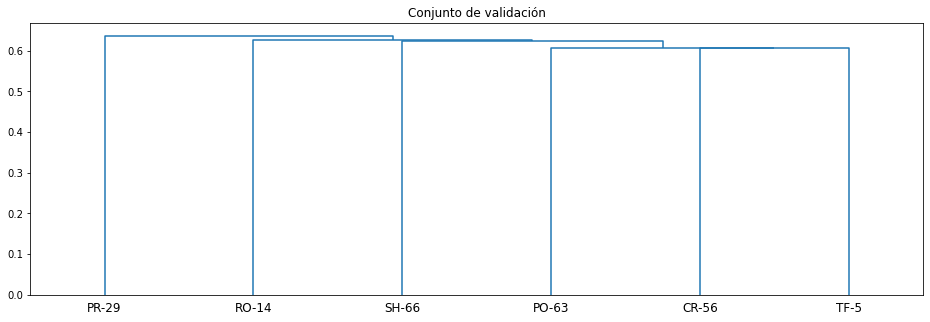

In [18]:
plt.figure(figsize=(16, 5))
dists = squareform(matrices['val'])
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=display_headers)
plt.title("Conjunto de validación")
plt.show()

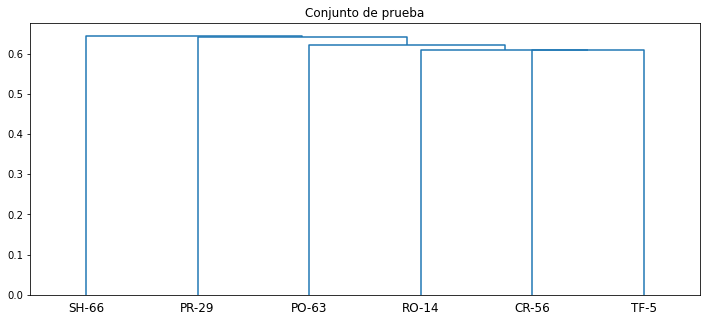

In [19]:
plt.figure(figsize=(12, 5))
dists = squareform(matrices['test'])
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=display_headers)
plt.title("Conjunto de prueba")
plt.show()